<h1 style="text-decoration:underline;text-align:center;font-family:'Sans serif';font-size:32px;color:Orange;">Data Analytics Model generation and evaluation</h1>

<div style="padding:0px 30px;font-size:16px;">This notebook makes use of the data that we have been given, and produces a number of predictive models that are compared against each other with the end-goal of prediciting percentage occupancy of a room.<br><br>
<h3>There are 3 primary scenarios regarding the availability of data for the rooms:</h3><br>
<ol>
<li>Some rooms have WiFi data logs, timetable and module data, and general room data</li>
<li>Some rooms do not have WiFi log data. However, given the ability to upload new data, it is possible that a room may have timetable/module information available, but no wifi logs.</li>
<li>And lastly, some rooms may only have information about the room itself (e.g. capacity, room type etc.)</li>
</ol><br><br>
Throughout the notebook, we exhaustively explore the best possible combination of features to use in our predictive models, depending on the data available.  In line with the 3 cases listed above, we will produce 3 model classifiers that, given certain inputs, will predict a room's occupancy.
<br><br>
The more data available to generate and train the model on, the more reliable it will be, so the last 2 model classifiers will be less accurate than the primary one, but may be used until the relevant data required by the first model is made available.
<br><br>
As a result of this approach, much of the code below will be executed 3 times -- once for each model's available dataset.  Variables ending in "2" denote those related to the second case model, and those ending in "3" represent the third case.</div>

In [70]:
#IMPORT ALL THE REQUIRED PACKAGES.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import linear_model
from sklearn import svm
from sklearn import preprocessing
from sklearn.feature_extraction import DictVectorizer
from sklearn.externals.six import StringIO
import pickle
import re
import os

# Ignore deprecation warnings
import warnings
warnings.filterwarnings('ignore')


# Allow plots to display in the notebook
%matplotlib inline


## Fetching data from the database

In [2]:
import calendar
from datetime import datetime
import MySQLdb
import pandas as pd

format_timestamp = lambda x:datetime.fromtimestamp(int(x))
format_weekday = lambda x:calendar.day_name[x]


def split_timestamp(df):
    ##iterate through all rows and split column timestamp for three different values
    # Michael: added months and years here for faster queries
    weekdays, dates, times, months, years = [], [], [], [], []
    for timestamp in df["timestamp"]:
        weekdays.append(timestamp.weekday())
        dates.append(timestamp.strftime("%Y-%m-%d"))
        times.append(timestamp.strftime("%H:%M:%S"))
        months.append(timestamp.strftime("%B"))
        years.append(int(timestamp.strftime("%Y")))
    return weekdays, dates, times, months, years


def format_timerange(x):
    #change column time to format in range 9:00 - 10:00, 10:00-11:00 etc
    hour = int(x.split(':')[0])  # split time,choose first element (hour) and change to integer
    return "{}:00-{}:00".format(str(hour).zfill(2), str(hour+1).zfill(2))  # zfill adds extra zero to the hour

#function as an argument takes input dataframe and returns dataframe with added extra columns Weekday,Date, Time
def prepare_timestamp(df):
    #convert the unix timestamp into regular datetime
    
   
    df["timestamp"] = df["timestamp"].map(format_timestamp)
    
    #split column timestamp for three different values and assign columns name
    weekdays, dates, times, months, years = split_timestamp(df)

    df['Weekday'] = weekdays
    df['Date'] = dates
    df['Time'] = times
    
    # Included these for faster queries
    df['Month'] = months
    df['Year'] = years

    
    df['Weekday'] = df['Weekday'].map(format_weekday)#Mapping weekday number to name (Monday, Tuesday, Wednesday, Thursday, Friday)
    
    #remove Saturday and Sunday from dataframe
    df = df[(df['Weekday'] != 'Saturday') & (df['Weekday'] != 'Sunday')]
    
   
    #set index on timestamp to choose time between 09:00 - 17:00
    df = df.set_index('timestamp')
    df = df.between_time('09:00','17:00')
    
    #change column time to format in range 9:00 - 10:00, 10:00-11:00 etc
    df['Time'] = df['Time'].map(format_timerange) #Map iterates over each element of a series. 
    
    return df

db = MySQLdb.connect(host="localhost",    # localhost
                     user="root",         # username
                     passwd="Harmony",   # password
                     db="Harmony_Data_Test")      # name of the data base


logs_df = pd.read_sql(sql="select room_id, timestamp, authenticated, associated from wifi ", con = db)
ground_df = pd.read_sql(sql="select r.capacity, r.type, r.room_id, s.occupied, s.occupancy, s.timestamp from survey as s join room as r on s.room_id = r.room_id", con = db)
timetable_df = pd.read_sql(sql="select c.timestamp, c.room_id, c.code,m.total_students from class as c join module as m on c.code = m.code ", con = db)

db.close() 


#split column timestamp for three different values
logs_df = prepare_timestamp(logs_df)
ground_df = prepare_timestamp(ground_df)
timetable_df = prepare_timestamp(timetable_df)

### Selecting max value of Associated for each column from logs_df table

In [3]:
hours = ["{}:00".format(hour) for hour in range(9, 18)]  #we get list: ['9:00', '10:00', ..., '16:00']

output_data = pd.DataFrame(columns=logs_df.columns)  #creating empty output table based on input table

for room in logs_df['room_id'].unique():  # for each room
    room_data = logs_df[logs_df['room_id'] == room]  #select data only from the room
    for date in room_data['Date'].unique():  # for each date
        date_logs_df = room_data[room_data['Date'] == date]  #selec data only form the date
        
        for index in range(len(hours)-1):  # for each range of hour
            time_data = date_logs_df.between_time(hours[index], hours[index+1])  #select only data from a given time period
            if time_data["associated"].count(): #checking whether a given period of time, there is at least one row 
                max_value = time_data["associated"].max()  # choosing the max Assoc from selected data
                max_time_data = time_data[time_data["associated"] == max_value].iloc[0]  #selecting a first element of a maximum value of a column
                output_data = output_data.append(max_time_data)  #append a row to the output data

# NOTE:
## The following generates and tidies up 3 pandas dataframes: result, result2, result3

### As stated in the introduction, these refer to the different levels of data availability

### Merging three tables - output_data, ground_df, timetable_df on the same column's name room_id, Weekday, Date, Time

In [4]:
# All data available
result = output_data.merge(ground_df,on=['room_id','Weekday','Date','Time', 'Month', 'Year']).merge(timetable_df,on=['room_id','Weekday','Date','Time', 'Month', 'Year'])

In [5]:
# No wifi data available
result2 = pd.merge(ground_df, timetable_df, on=['room_id','Weekday','Date','Time', 'Month', 'Year'])

In [6]:
# No wifi or module data available
result3 = ground_df[:]

In [7]:
# Drop the "Date" column, as this information is represented in other columns
result = result.drop(["Date"], axis=1)
result2 = result2.drop(["Date"], axis=1)
result3 = result3.drop(["Date"], axis=1)

## Display the dataframes:

In [8]:
result.head()

,room_id,authenticated,associated,Weekday,Time,Month,Year,capacity,type,occupied,occupancy,code,total_students
0,B002,9.0,9.0,Friday,09:00-10:00,November,2015.0,90,Classroom,0,0,COMP30220,38
1,B002,17.0,17.0,Friday,10:00-11:00,November,2015.0,90,Classroom,0,0,not available,0
2,B002,19.0,19.0,Friday,11:00-12:00,November,2015.0,90,Classroom,0,0,COMP30190,29
3,B002,20.0,20.0,Friday,12:00-13:00,November,2015.0,90,Classroom,0,0,COMP30190,29
4,B002,16.0,16.0,Friday,13:00-14:00,November,2015.0,90,Classroom,0,0,COMP30170,51


In [9]:
result2.head()

,capacity,type,room_id,occupied,occupancy,Weekday,Time,Month,Year,code,total_students
0,90,Classroom,B002,1,25,Monday,09:00-10:00,November,2015,COMP30190,29
1,90,Classroom,B002,1,50,Monday,10:00-11:00,November,2015,COMP40660,53
2,90,Classroom,B002,1,25,Monday,11:00-12:00,November,2015,not available,0
3,90,Classroom,B002,1,25,Monday,12:00-13:00,November,2015,COMP30250,22
4,90,Classroom,B002,1,50,Monday,13:00-14:00,November,2015,COMP41690,60


In [10]:
result3.head()

,capacity,type,room_id,occupied,occupancy,Weekday,Time,Month,Year
timestamp,,,,,,,,,
2015-11-02 09:00:00,90,Classroom,B002,1,25,Monday,09:00-10:00,November,2015
2015-11-02 10:00:00,90,Classroom,B002,1,50,Monday,10:00-11:00,November,2015
2015-11-02 11:00:00,90,Classroom,B002,1,25,Monday,11:00-12:00,November,2015
2015-11-02 12:00:00,90,Classroom,B002,1,25,Monday,12:00-13:00,November,2015
2015-11-02 13:00:00,90,Classroom,B002,1,50,Monday,13:00-14:00,November,2015


In [11]:
#GIVE THEM COLUMN NAMES
result.columns = ["Room", "Authenticated", "Associated", "Day", "Time", "Month", "Year", "Capacity", "Type", 
                 "Over3", "TARGET", "Module", "Registered"]

result2.columns = ["Capacity", "Type", "Room", "Over3", "TARGET", "Day", "Time", "Month", "Year", 
                 "Module", "Registered"]

result3.columns = ["Capacity", "Type", "Room", "Over3", "TARGET", "Day", "Time", "Month", "Year"]

# Re-order the columns as desired
new_cols = ["Time", "Day", "Month", "Year", "Module", "Room", "Type", "Capacity", "Registered", "Authenticated", "Associated", "Over3", "TARGET"]
result = result[new_cols]

In [12]:
# Output complete table to csv file
result.to_csv("TableABT.csv")

# Some manual encoding

We create a number of dictionaries to manually map categorical features to integers.  The rest will be done later with a scikit-learn function, but by manually assigning these ones we can ensure that certain categorical features are always mapped to certain integers.

This is important, for example, in some of our Flask functions that rely on the months of the year being assigned their correct integer values.

If the dataframe is in a different order before encoding, we cannot guarantee that "January" will be mapped to "1".

In [13]:
# Allow for easy conversion between days/months and fixed integers
day_dict = {
    "Monday":0,
    "Tuesday":1,
    "Wednesday":2,
    "Thursday":3,
    "Friday":4,
    "Saturday":5,
    "Sunday":6
}

month_dict = {
    "January":1,
    "February":2,
    "March":3,
    "April":4,
    "May":5,
    "June":6,
    "July":7,
    "August":8,
    "September":9,
    "October":10,
    "November":11,
    "December":12
}

# List of what the module codes map to
module_codes = {'COMP30190': 15, 'COMP10280': 2, 'COMP47300': 27, 'STAT40150': 32, 
                'COMP40370': 21, 'COMP20020': 4, 'COMP30250': 18, 'COMP30120': 13,
                'COMP41690': 25, 'not available': 33, 'SCI30060': 31, 'COMP30060': 9,
                'COMP40660': 22, 'MATH10200': 30, 'COMP30080': 11, 'COMP30520': 20,
                'ENVB30110': 28, 'MATH10130': 29, 'COMP20010': 3, 'COMP20130': 7,
                'COMP30110': 12, 'COMP20110': 6, 'COMP30070': 10, 'COMP20070': 5,
                'COMP30240': 17, 'COMP30010': 8, 'COMP30170': 14, 'COMP30260': 19,
                'COMP41110': 23, 'COMP30220': 16, 'COMP47290': 26, 'COMP10130': 1,
                'COMP10110': 0, 'COMP41450': 24, 'IS40640': 34}
# Room types
type_codes = {'Classroom':0, 'Lecture Theatre':1, 'A.L.E.':2, 'Seminar':3}

In [14]:
# Use the above dictionaries to manually encode days and months to always be the correct integer
day_list = []
month_list = []
module_list = []
type_list = []
for i in range(len(result)):
    month_list.append(month_dict[result.iloc[i]["Month"]])
    day_list.append(day_dict[result.iloc[i]["Day"]])
    module_list.append(module_codes[result.iloc[i]["Module"]])
    type_list.append(type_codes[result.iloc[i]["Type"]])
# Reassign to the dataframe
result.Day = day_list
result.Month = month_list
result.Module = module_list
result.Type = type_list

# Same thing for dataframe without WiFi
day_list2 = []
month_list2 = []
module_list2 = []
type_list2 = []
for i in range(len(result2)):
    month_list2.append(month_dict[result2.iloc[i]["Month"]])
    day_list2.append(day_dict[result2.iloc[i]["Day"]])
    module_list2.append(module_codes[result2.iloc[i]["Module"]])
    type_list2.append(type_codes[result2.iloc[i]["Type"]])
result2.Day = day_list2
result2.Month = month_list2
result2.Module = module_list2
result2.Type = type_list2

# Same thing for dataframe without WiFi and Modules
day_list3 = []
month_list3 = []
type_list3 = []
for i in range(len(result3)):
    month_list3.append(month_dict[result3.iloc[i]["Month"]])
    day_list3.append(day_dict[result3.iloc[i]["Day"]])
    type_list3.append(type_codes[result3.iloc[i]["Type"]])
result3.Day = day_list3
result3.Month = month_list3
result3.Type = type_list3

# Preprocessing
This stage in the model building is getting the data in the required form for our model 

## Encode categorical Features
For feature selection and model evaluation to be tight the categorical features will be enoded into integers ffor the models

In [15]:
# ENCODE THE FOLLOWING CATEGORICAL FEATURES INTO INTEGERS
# Others have been done above, so as to remain consistent
column_names = ['Time', 'Room', 'TARGET']

# SUCCINT FUNCTION FOR INTEGER REPRESENTATION
lab_enc = preprocessing.LabelEncoder()

# ITERATIVELY ENCODE ALL THE COLUMNS for each dataframe
for name in column_names:
    if name in result.columns:
        result[name] = lab_enc.fit_transform(result[name])
    if name in result2.columns:
        result2[name] = lab_enc.fit_transform(result2[name])
    if name in result3.columns:
        result3[name] = lab_enc.fit_transform(result3[name])

In [16]:
# Output full encoded dataframe to csv
result.to_csv("EncodedABT.csv")

# Feature Selection Procedure

This micro-program creates a nested list with every possible feature cobination for our experimental procedure.
The combination will be of every feature that won't result in overfitting.

### Features List
1. Room
2. Capacity 
3. Type
4. Day
5. Month
6. Year
7. Time 
8. Module#
9. Registered 
10. Associated 
11. Authenticated 



# Different descriptive features available
### So create target vectors and training matrices for each model

In [17]:
# Case 1
all_descriptive = ['Day', 'Time', 
                   'Module', 'Room', 'Capacity', 
                   'Type', 'Registered', 
                   'Authenticated', 'Associated', 'Year', 'Month']

X = result[all_descriptive]
Y = result['TARGET']

In [18]:
# Case 2
all_descriptive2 = ['Day', 'Time', 
                   'Module', 'Room', 'Capacity', 
                   'Type', 'Registered', 
                   'Year', 'Month']

X2 = result2[all_descriptive2]
Y2 = result2['TARGET']

In [19]:
# Case 3
all_descriptive3 = ['Day', 'Time', 'Room', 'Capacity', 
                   'Type', 'Year', 'Month']

X3 = result3[all_descriptive3]
Y3 = result3['TARGET']

## Variance threshold 

In [20]:
from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold(threshold=(.8 * (1 - .8)))

features = sel.fit_transform(X)
features[0]

array([  4.,   0.,  16.,   0.,  90.,   0.,  38.,   9.,   9.])

In [21]:
# Case 2
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))

features2 = sel.fit_transform(X2)
features2[0]

array([ 0,  0, 15,  0, 90,  0, 29])

In [22]:
# Case 3
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))

features3 = sel.fit_transform(X3)
features3[0]

array([ 0,  0,  0, 90,  0])

## Univariate Feature Selection

In [23]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X_new = SelectKBest(chi2, k=11).fit_transform(X, Y)

df = pd.DataFrame(X_new, columns=['Day', 'Month', 'Year', 'Time', 'Module', 'Room', 'Capacity', 'Type', 'Registered', 'Authenticated', 'Associated'])

columns = df.columns

In [24]:
# Case 2
X_new2 = SelectKBest(chi2, k=9).fit_transform(X2, Y2)

df2 = pd.DataFrame(X_new2, columns=['Day', 'Month', 'Year', 'Time', 'Module', 'Room', 'Capacity', 'Type', 'Registered'])

columns2 = df2.columns

In [25]:
# Case 3
X_new3 = SelectKBest(chi2, k=7).fit_transform(X3, Y3)

df3 = pd.DataFrame(X_new3, columns=['Day', 'Month', 'Year', 'Time', 'Room', 'Capacity', 'Type'])

columns3 = df3.columns

## Recursive Feature Elimination Program
This program gets rid of the remaining features by trying every combination

In [26]:
# OUTPUT EVERY COMBINATION OF FEATURES #MICRO-PROGRAM TO 
import itertools

feature_combinations = []
feature_combinations2 = []
feature_combinations3 = []

# Case 1
for L in range(0, len(columns)+1):
    for subset in itertools.combinations(columns, L):
        feature_combinations.append(list(subset))
# Case 2
for L in range(0, len(columns)+1):
    for subset in itertools.combinations(columns2, L):
        feature_combinations2.append(list(subset))
# Case 3
for L in range(0, len(columns)+1):
    for subset in itertools.combinations(columns3, L):
        feature_combinations3.append(list(subset))   

# Cleanup    
del feature_combinations[0]
del feature_combinations2[0]
del feature_combinations3[0]

## Feature Combinations
Now we have the narrowed down feature combinations to try with the models

In [27]:
# Showing all feature combinations for case 1
for el in feature_combinations:
    print(el)

['Day']
['Month']
['Year']
['Time']
['Module']
['Room']
['Capacity']
['Type']
['Registered']
['Authenticated']
['Associated']
['Day', 'Month']
['Day', 'Year']
['Day', 'Time']
['Day', 'Module']
['Day', 'Room']
['Day', 'Capacity']
['Day', 'Type']
['Day', 'Registered']
['Day', 'Authenticated']
['Day', 'Associated']
['Month', 'Year']
['Month', 'Time']
['Month', 'Module']
['Month', 'Room']
['Month', 'Capacity']
['Month', 'Type']
['Month', 'Registered']
['Month', 'Authenticated']
['Month', 'Associated']
['Year', 'Time']
['Year', 'Module']
['Year', 'Room']
['Year', 'Capacity']
['Year', 'Type']
['Year', 'Registered']
['Year', 'Authenticated']
['Year', 'Associated']
['Time', 'Module']
['Time', 'Room']
['Time', 'Capacity']
['Time', 'Type']
['Time', 'Registered']
['Time', 'Authenticated']
['Time', 'Associated']
['Module', 'Room']
['Module', 'Capacity']
['Module', 'Type']
['Module', 'Registered']
['Module', 'Authenticated']
['Module', 'Associated']
['Room', 'Capacity']
['Room', 'Type']
['Room', 'R

In [28]:
# HOW MANY COMBINATIONS TO BE compared

print "Case 1:", (len(feature_combinations))
print "Case 2:", (len(feature_combinations2))
print "Case 3:", (len(feature_combinations3))

Case 1: 2047
Case 2: 511
Case 3: 127


# MODEL EVALUATION PROCEDURE

This is an experiment emulated from the Diabetes Kaggle project. The  Case Study so as we can empiracly try supervised learning models to see which ones work the best.

### Estimators
Instantiate all models pertaining to our specific task.
All the models which fall under supervised learning, specific predictive
output and examine descriptiv etarget relationships
Algorithms make intuitive sense for problem

In [29]:
# DECISION TREE
from sklearn import tree
tree = tree.DecisionTreeClassifier()

# K NEAREST NEIGHBOURS
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

# LOGISTIC REGRESSION
from sklearn import linear_model
logreg = linear_model.LogisticRegression()

# LINEAR REGRESSION
linear = linear_model.LinearRegression()

## Model Evaluation Procedure

1. Cross validation
2. Placeholding framework for the models
3. Able to try model with each combination of features with the best p values

In [30]:
def feature_model_comb(model):
    #CROSS VALIDATION
    from sklearn.cross_validation import cross_val_score

    #This will keep track of the results of each feature combination used with each model.
    compare_results = []
    compare_results2 = []
    compare_results3 = []

    #This just prints integer signature for each combination
    combination_labels = range(len(feature_combinations))
    combination_labels2 = range(len(feature_combinations2))
    combination_labels3 = range(len(feature_combinations3))
        
    for combination in feature_combinations:
        # PANDAS trick to change columns quickly
        X = df.as_matrix(columns = combination)
        y = result.as_matrix(columns = ['TARGET']).ravel()

        # Use cross validation accuracy for better generalisation    
        # Get the mean of the results 
        # USE THIS LINE FOR CATEGORICAL FEATURES
        compare_results.append(cross_val_score(model, X, y, cv=10, scoring='accuracy').mean())
        
        # USE THIS LINE FOR CONTINUOUS FEATURES        
        # scores = cross_val_score(knn, X, y, cv=10, scoring='mean_squared_error')        
    
    # Exactly the same thing for the lists without wifi data
    for combination in feature_combinations2:
        X = df2.as_matrix(columns = combination)
        y = result2.as_matrix(columns = ['TARGET']).ravel()
        compare_results2.append(cross_val_score(model, X, y, cv=10, scoring='accuracy').mean())
    
    # And same thing again excluding wifi and timetable data
    for combination in feature_combinations3:
        X = df3.as_matrix(columns = combination)
        y = result3.as_matrix(columns = ['TARGET']).ravel()
        compare_results3.append(cross_val_score(model, X, y, cv=10, scoring='accuracy').mean())
        
    # Return all results as well as lists
    return [[combination_labels, combination_labels2, combination_labels3], [compare_results, compare_results2, compare_results3]]


## TREE EVALUATE

In [31]:
tree_results = feature_model_comb(tree) 

## PLOT RESULTS OF TREE WITH EACH FEATURE COMB
Cross validation brings the accuracy down so mid 50s is what we are looking for

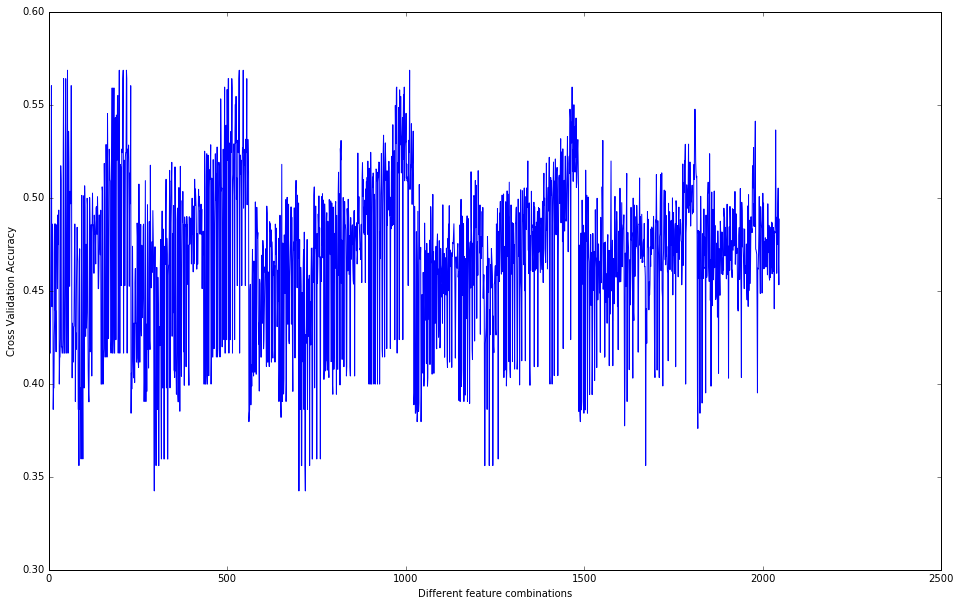

In [32]:
# Plot for when all data is available
plt.figure(figsize=(16,10))
plt.plot(tree_results[0][0], tree_results[1][0])
plt.xlabel('Different feature combinations')
plt.ylabel('Cross Validation Accuracy')

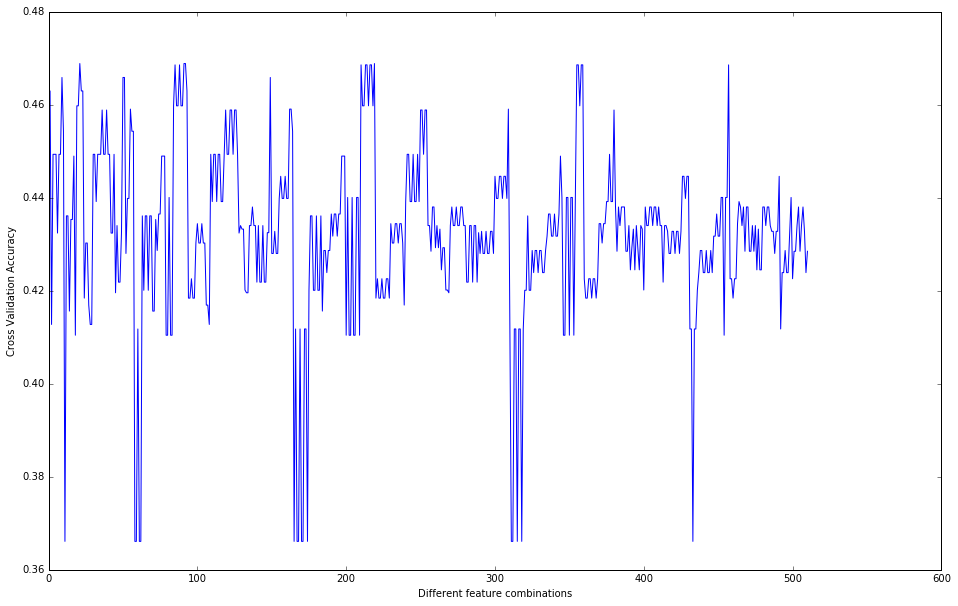

In [33]:
# Plot for when wifi data is not available
plt.figure(figsize=(16,10))
plt.plot(tree_results[0][1], tree_results[1][1])
plt.xlabel('Different feature combinations')
plt.ylabel('Cross Validation Accuracy')

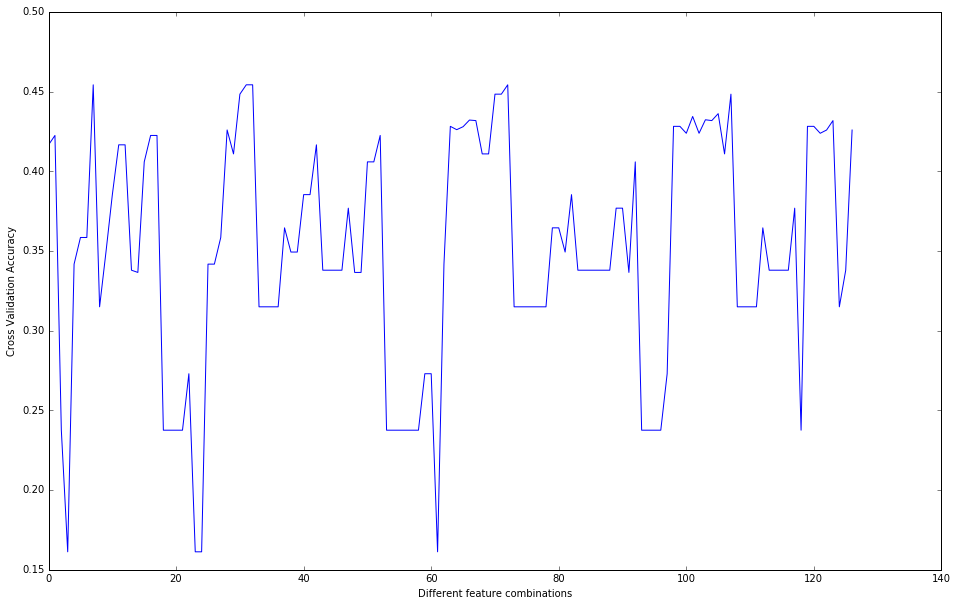

In [34]:
# Plot for when module and wifi data are not available
plt.figure(figsize=(16,10))
plt.plot(tree_results[0][2], tree_results[1][2])
plt.xlabel('Different feature combinations')
plt.ylabel('Cross Validation Accuracy')

In [35]:
# Find the combination that gave the best accuracy score
results = tree_results[1][0]
maximum = max(enumerate(results), key=lambda x: (x[1], x[0]))[0]

In [36]:
# Find the combination that gave the best accuracy score
results2 = tree_results[1][1]
maximum2 = max(enumerate(results2), key=lambda x: (x[1], x[0]))[0]

In [37]:
# Find the combination that gave the best accuracy score
results3 = tree_results[1][2]
maximum3 = max(enumerate(results3), key=lambda x: (x[1], x[0]))[0]

# Feature combinations giving the best accuracy scores

In [38]:
# Case 1
feature_combinations[maximum]

['Module', 'Room', 'Registered', 'Authenticated', 'Associated']

In [39]:
# Case 2
feature_combinations2[maximum2]

['Month', 'Capacity', 'Type', 'Registered']

In [40]:
# Case 3
feature_combinations3[maximum3]

['Day', 'Month', 'Capacity', 'Type']

## KNN EVALUATE

In [41]:
knn_results = feature_model_comb(knn)

## PLOT RESULTS OF TREE WITH EACH FEATURE COMB
Cross validation brings the accuracy down so mid 50s is what we are looking for

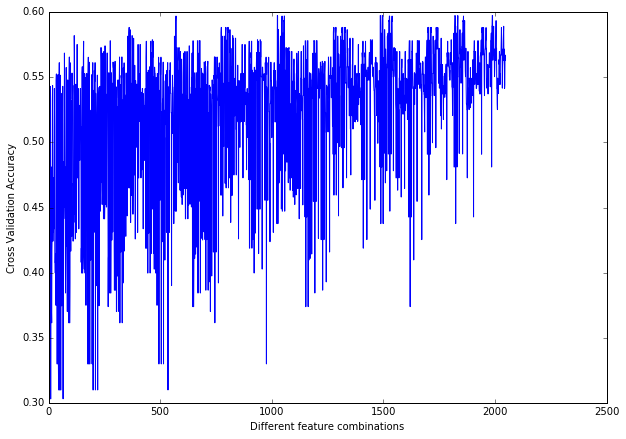

In [42]:
# Plot for when all data is available
plt.figure(figsize=(10,7))
plt.plot(knn_results[0][0], knn_results[1][0])
plt.xlabel('Different feature combinations')
plt.ylabel('Cross Validation Accuracy')

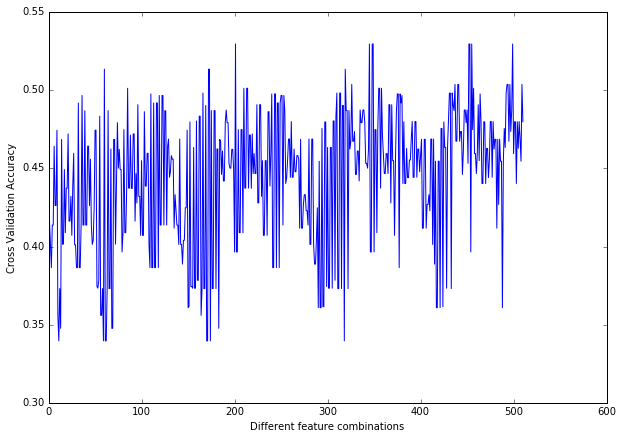

In [43]:
# Plot for when wifi data is absent
plt.figure(figsize=(10,7))
plt.plot(knn_results[0][1], knn_results[1][1])
plt.xlabel('Different feature combinations')
plt.ylabel('Cross Validation Accuracy')

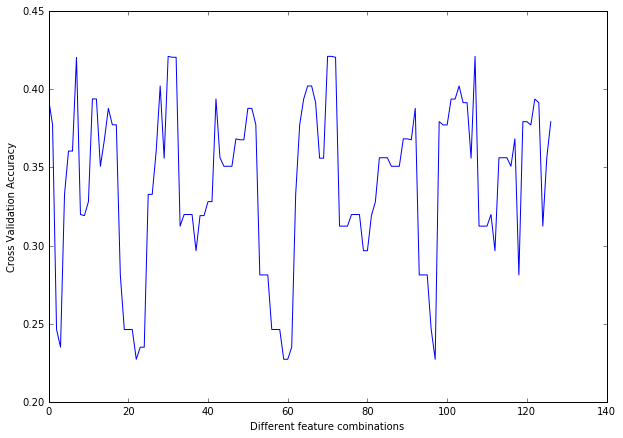

In [44]:
# Plot for when wifi and module data are absent
plt.figure(figsize=(10,7))
plt.plot(knn_results[0][2], knn_results[1][2])
plt.xlabel('Different feature combinations')
plt.ylabel('Cross Validation Accuracy')

# LOG REG 
## This first code block takes a while to run!

In [45]:
logreg_results = feature_model_comb(logreg)

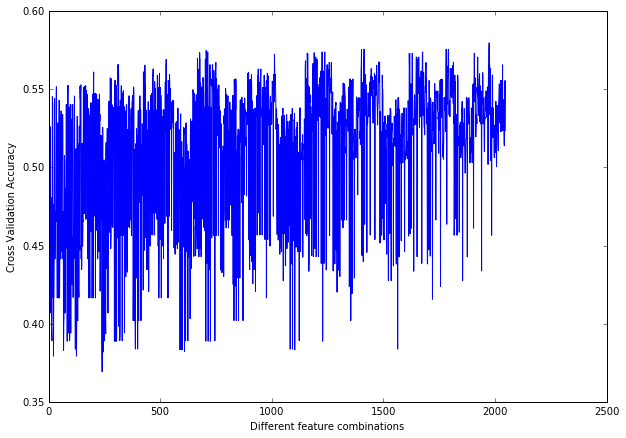

In [46]:
# All data available
plt.figure(figsize=(10,7))
plt.plot(logreg_results[0][0], logreg_results[1][0])
plt.xlabel('Different feature combinations')
plt.ylabel('Cross Validation Accuracy')

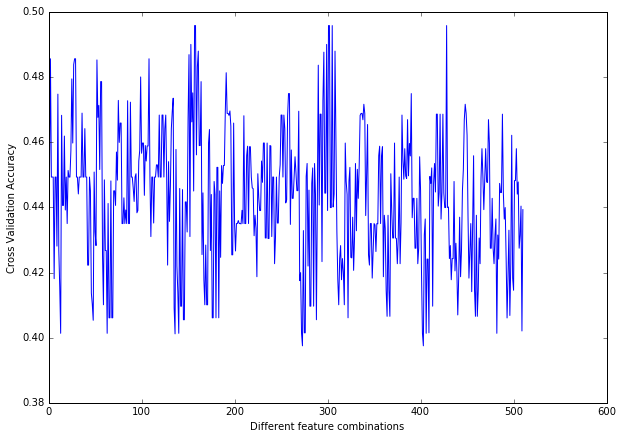

In [47]:
# Wifi data not available
plt.figure(figsize=(10,7))
plt.plot(logreg_results[0][1], logreg_results[1][1])
plt.xlabel('Different feature combinations')
plt.ylabel('Cross Validation Accuracy')

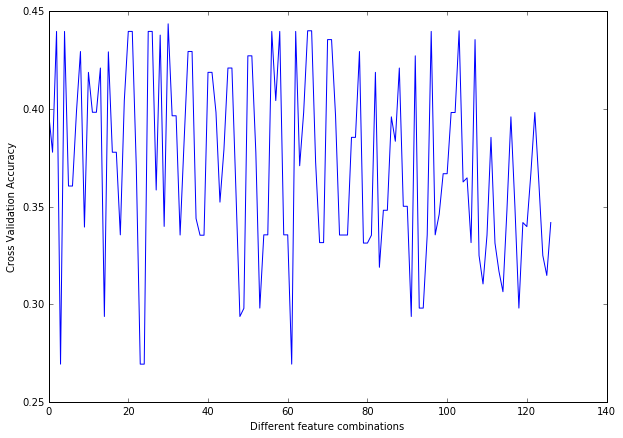

In [48]:
# Wifi and module data not available
plt.figure(figsize=(10,7))
plt.plot(logreg_results[0][2], logreg_results[1][2])
plt.xlabel('Different feature combinations')
plt.ylabel('Cross Validation Accuracy')

In [50]:
# All data available
knn_result = max(knn_results[1][0])
tree_result = max(tree_results[1][0])
logreg_result = max(logreg_results[1][0])

models = range(3)
model_results = [knn_result, tree_result, logreg_result]

In [51]:
# No wifi data available
knn_result2 = max(knn_results[1][1])
tree_result2 = max(tree_results[1][1])
logreg_result2 = max(logreg_results[1][1])

models2 = range(3)
model_results2 = [knn_result2, tree_result2, logreg_result2]

In [52]:
# No wifi or module data
knn_result3 = max(knn_results[1][2])
tree_result3 = max(tree_results[1][2])
logreg_result3 = max(logreg_results[1][2])

models3 = range(3)
model_results3 = [knn_result3, tree_result3, logreg_result3]

## COMPARE ALL MODELS

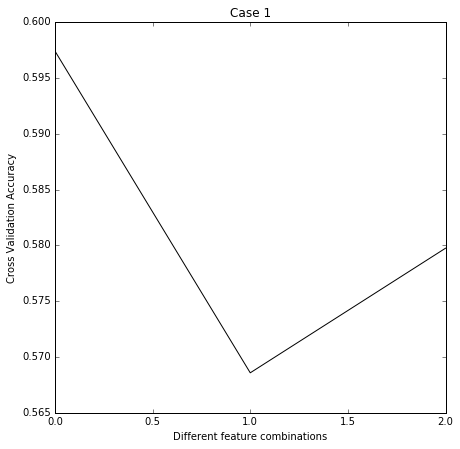

In [58]:
plt.figure(figsize=(7,7))
plt.plot(models, model_results, 'k')
plt.xlabel('Different feature combinations')
plt.ylabel('Cross Validation Accuracy')
plt.title("Case 1")

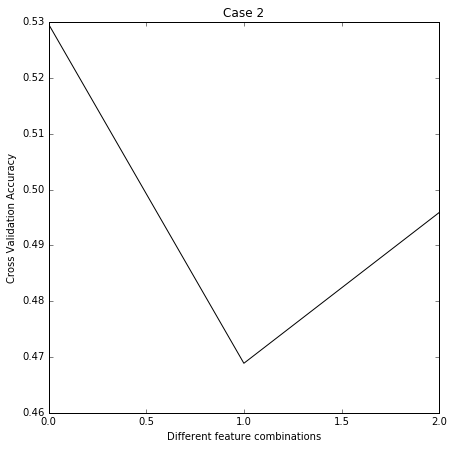

In [59]:
plt.figure(figsize=(7,7))
plt.plot(models2, model_results2, 'k')
plt.xlabel('Different feature combinations')
plt.ylabel('Cross Validation Accuracy')
plt.title("Case 2")

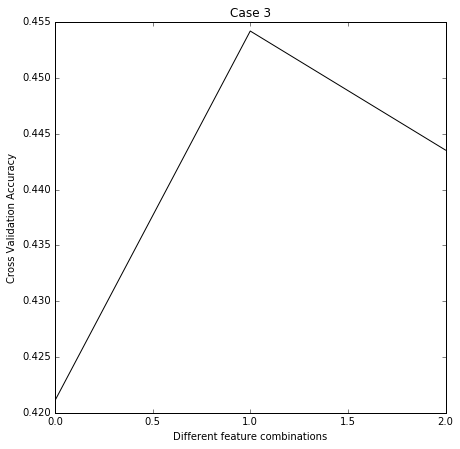

In [60]:
plt.figure(figsize=(7,7))
plt.plot(models3, model_results3, 'k')
plt.xlabel('Different feature combinations')
plt.ylabel('Cross Validation Accuracy')
plt.title("Case 3")

## Interpretation of above graph

- 0.0 = LOGREG
- 1.0 = A DECISION TREE
- 2.0 = A K NEAREST NEIGHBOURS
The best feature combination with the best model is a decision tree. This is the model we will choose for parameter tuning

# TREE; Parameter Tuning Procedure

THis is accomplished by creating a dictionarial grid of each parameter with it's possible values
A function is SCikit learn tries every combination

## Create Parameter Grid

In [61]:
from sklearn.grid_search import GridSearchCV

#PARAMETER VALUES
criterion_options = ['gini', 'entropy']
splitter_options = ['best', 'random']
presort_options = [True, False]
max_fea_range_op = list(range(20))
max_depth_op = list(range(1, 30))
min_samples_leaf_op = list(range(1, 4))

k_range = list(range(1, 91))

#GRID
param_grid = dict(criterion=criterion_options, splitter=splitter_options,
                  presort= presort_options, max_depth=max_depth_op, 
                  min_samples_leaf=min_samples_leaf_op)

## Execute the grid 
Use every parameter combination

In [62]:
grid = GridSearchCV(tree, param_grid, cv=10, scoring='accuracy')

In [63]:
X = result.as_matrix(columns = ['Module', 'Room', 'Registered', 'Authenticated', 'Associated'])
Y = result.as_matrix(columns = ['TARGET']).ravel()

In [64]:
grid.fit(X, Y)

GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'presort': [True, False], 'splitter': ['best', 'random'], 'criterion': ['gini', 'entropy'], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 'min_samples_leaf': [1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [65]:
grid.grid_scores_

[mean: 0.49541, std: 0.09904, params: {'presort': True, 'splitter': 'best', 'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1},
 mean: 0.47248, std: 0.10120, params: {'presort': True, 'splitter': 'random', 'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1},
 mean: 0.49541, std: 0.09904, params: {'presort': False, 'splitter': 'best', 'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1},
 mean: 0.45872, std: 0.06560, params: {'presort': False, 'splitter': 'random', 'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1},
 mean: 0.49541, std: 0.09904, params: {'presort': True, 'splitter': 'best', 'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 2},
 mean: 0.46330, std: 0.10930, params: {'presort': True, 'splitter': 'random', 'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 2},
 mean: 0.49541, std: 0.09904, params: {'presort': False, 'splitter': 'best', 'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 2},
 mean: 0.44037, std: 0.12590, pa

In [66]:
grid_mean_scores = [x.mean_validation_score for x in grid.grid_scores_]

labelling = list(range(len(grid_mean_scores)))
print(grid_mean_scores)

[0.49541284403669728, 0.47247706422018348, 0.49541284403669728, 0.45871559633027525, 0.49541284403669728, 0.46330275229357798, 0.49541284403669728, 0.44036697247706424, 0.49541284403669728, 0.47247706422018348, 0.49541284403669728, 0.44036697247706424, 0.51376146788990829, 0.52293577981651373, 0.51376146788990829, 0.5, 0.51376146788990829, 0.46330275229357798, 0.51376146788990829, 0.50917431192660545, 0.51376146788990829, 0.48623853211009177, 0.51376146788990829, 0.47706422018348627, 0.51376146788990829, 0.48623853211009177, 0.51834862385321101, 0.53669724770642202, 0.51376146788990829, 0.51376146788990829, 0.51376146788990829, 0.50458715596330272, 0.53669724770642202, 0.51834862385321101, 0.53669724770642202, 0.46330275229357798, 0.47706422018348627, 0.54128440366972475, 0.48623853211009177, 0.58715596330275233, 0.48165137614678899, 0.49541284403669728, 0.48165137614678899, 0.56880733944954132, 0.48165137614678899, 0.47706422018348627, 0.47706422018348627, 0.55045871559633031, 0.52293

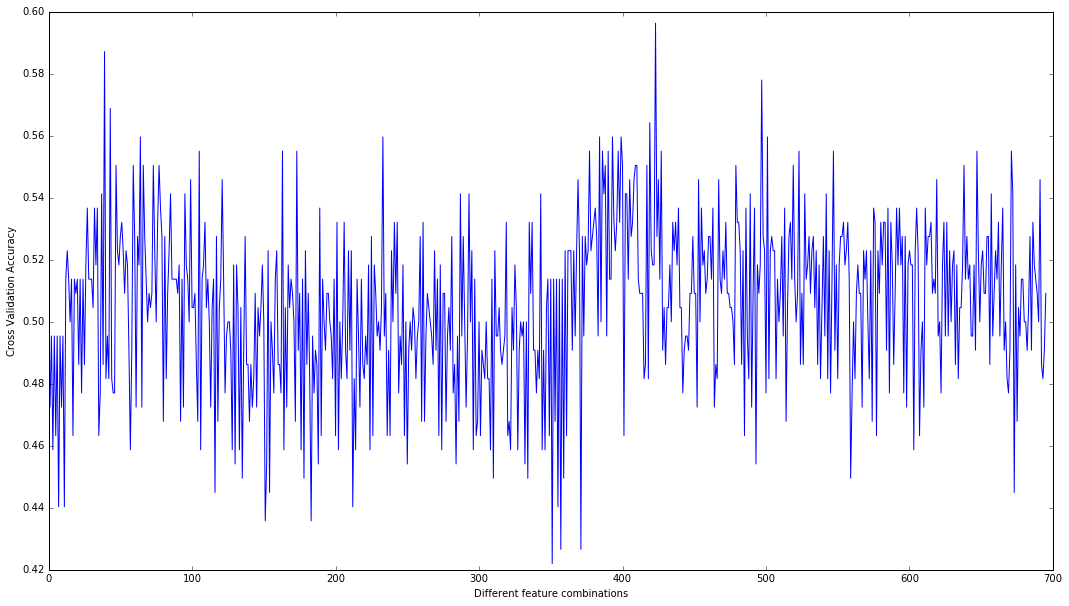

In [67]:
plt.figure(figsize=(18,10))
plt.plot(labelling, grid_mean_scores)
plt.xlabel('Different feature combinations')
plt.ylabel('Cross Validation Accuracy')

In [68]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.596330275229
{'presort': False, 'splitter': 'random', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 1}
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=7,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='random')


# FINISHED MODEL READY FOR DEPLOYMENT

In [71]:
# Create a directory to save the classifiers to
destination = os.path.join('occupancyclassifier', 'pk1objects')

if not os.path.exists(destination):
    os.makedirs(destination)
    
# Train the first classifier and save to pickle file
X = result.as_matrix(columns = ['Module', 'Room', 'Registered', 'Authenticated', 'Associated'])
y = result.as_matrix(columns = ['TARGET']).ravel()

tree.fit(X, y)
pickle.dump(tree, open(os.path.join(destination, 'occupancyclassfier.pk1'), 'wb'), protocol=2)    

#  Repeat for other classifiers

In [72]:
# Repeat for model without wifi data
X2 = result2.as_matrix(columns = ['Month', 'Capacity', 'Type', 'Registered'])
y2 = result2.as_matrix(columns = ['TARGET']).ravel()

tree.fit(X2, y2)
pickle.dump(tree, open(os.path.join(destination, 'occupancyclassfier2.pk1'), 'wb'), protocol=2)    

In [73]:
# And again for model without wifi or timetable data
X3 = result3.as_matrix(columns = ['Day', 'Month', 'Capacity', 'Type'])
y3 = result3.as_matrix(columns = ['TARGET']).ravel()

tree.fit(X3, y3)    
pickle.dump(tree, open(os.path.join(destination, 'occupancyclassfier3.pk1'), 'wb'), protocol=2)    

## Test Load

In [74]:
clf = pickle.load(open('occupancyclassifier/pk1objects/occupancyclassfier.pk1', 'rb'))

In [75]:
print(clf)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')


In [76]:
# Testing classifier
x = result[['Module', 'Room', 'Registered', 'Authenticated', 'Associated']].as_matrix()
print clf.predict(x)

[0 0 0 0 0 1 0 1 0 2 2 2 0 3 1 1 0 0 1 1 1 1 2 2 0 0 1 1 0 2 2 1 1 1 1 2 0
 1 0 0 1 0 1 1 1 0 2 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 2 1 1 1 1 2 0
 3 3 2 2 2 2 1 1 0 1 1 1 1 1 1 2 1 2 2 2 1 1 2 2 1 0 0 0 0 0 0 2 2 0 1 0 1
 2 0 0 0 0 4 4 1 1 1 2 1 0 0 0 0 1 1 0 0 0 0 0 2 1 1 2 1 0 0 1 1 1 1 1 1 2
 1 0 2 2 1 1 0 2 1 1 0 1 0 3 3 0 0 0 2 1 2 2 1 1 1 1 0 0 3 3 3 2 1 0 0 1 1
 2 1 0 0 1 3 1 1 0 3 3 2 0 0 3 1 2 1 0 0 0 0 1 1 1 0 0 0 2 2 1 0 0]


In [77]:
# Testing classifier 2
clf2 = pickle.load(open('occupancyclassifier/pk1objects/occupancyclassfier2.pk1', 'rb'))
print clf2.predict(result2[['Month', 'Capacity', 'Type', 'Registered']].as_matrix())

[1 1 0 1 1 1 0 1 0 2 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 0 2 1 1 0 1 1 1 0 0 1 1
 0 1 0 0 1 1 0 1 1 1 0 1 0 2 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 0 2 1 1 0 1 1 1
 0 0 1 1 0 1 0 0 1 1 2 2 0 2 2 0 0 0 2 0 0 0 0 0 0 0 3 3 0 0 0 0 0 0 2 0 0
 0 1 1 0 0 0 3 3 0 1 1 2 2 0 2 2 0 0 0 2 0 0 0 0 0 0 0 3 3 0 0 0 0 0 0 2 0
 0 0 1 1 0 0 0 3 3 0 1 1 1 1 1 0 0 1 1 1 1 1 2 0 1 0 1 0 1 1 0 0 0 0 1 1 1
 1 1 2 1 0 1 0 0 0 0 2 2 0 0 1 0 0 1 0 1 0 0 1 1 1 1 1 2 0 1 0 1 0 1 1 0 0
 0 0 1 1 1 1 1 2 1 0 1 0 0 0 0 2 2 0 0]


In [78]:
# Testing classifier 3
clf3 = pickle.load(open('occupancyclassifier/pk1objects/occupancyclassfier3.pk1', 'rb'))
print clf3.predict(result3[['Day', 'Month', 'Capacity', 'Type']].as_matrix())

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 4 4 4 4 4 4 4 4 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
